In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import os 
from tensorflow.keras.layers import TextVectorization
import warnings


warnings.filterwarnings('ignore', category=DeprecationWarning)
pd.set_option('display.max_columns', None)

/var/folders/kf/yv1zrfvd701c47vqp5xz4sjh0000gn/T/ipykernel_78537/171741968.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/mikosa/tensor/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
gpus = tf.config.experimental.list_physical_devices('gpu')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
df = pd.read_csv('data/train.csv')

In [4]:
df.shape

(159571, 8)

In [5]:
df.head()


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
samp = df.sample(frac= 0.10)

In [7]:
X = samp['comment_text']
y = samp[df.columns[2:]].values 

In [8]:
max_features = 200000

In [9]:
vectorizer = TextVectorization(max_tokens = max_features, output_sequence_length = 1800, \
                               output_mode = 'int')

2024-02-22 12:08:19.561510: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-02-22 12:08:19.561536: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-02-22 12:08:19.561546: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-02-22 12:08:19.561979: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-22 12:08:19.562525: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
vectorizer.get_vocabulary()

['', '[UNK]']

In [11]:
vectorizer.adapt(X.values)

2024-02-22 12:08:19.755004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [12]:
vectorizer_text = vectorizer(X.values)

In [13]:
dataset = tf.data.Dataset.from_tensor_slices((vectorizer_text, y))

In [14]:
dataset = dataset.cache()
dataset = dataset.shuffle(60000)
dataset = dataset.batch(32)
dataset = dataset.prefetch(16)

In [15]:
batch_x, batch_y = dataset.as_numpy_iterator().next()

In [16]:
train = dataset.take(int(len(dataset)*0.7))
val = dataset.skip(int(len(dataset)*0.7)).take(int(len(dataset)*0.2))
test = dataset.skip(int(len(dataset)*0.9)).take(int(len(dataset)*0.1))

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Embedding, Dense

In [18]:
model = Sequential()

In [19]:
model.add(Embedding(max_features +1, 32))
model.add(Bidirectional(LSTM(32, activation='tanh')))
# model.add(Dense(128, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
# model.add(Dense(128, activation = 'relu'))
# model.add(Dense(256, activation = 'relu'))
model.add(Dense(6, activation = 'sigmoid'))

In [20]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 dense_1 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 6434854 (24.55 MB)
Trainable params: 6434854 (24.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
history = model.fit(train, epochs=5, validation_data=val)

Epoch 1/5
349/349 [==============================] - 92s 260ms/step - loss: 0.1402 - accuracy: 0.9080 - val_loss: 0.0694 - val_accuracy: 0.9937
Epoch 2/5
349/349 [==============================] - 88s 253ms/step - loss: 0.0648 - accuracy: 0.9600 - val_loss: 0.0523 - val_accuracy: 0.9908
Epoch 3/5
349/349 [==============================] - 97s 277ms/step - loss: 0.0473 - accuracy: 0.9898 - val_loss: 0.0406 - val_accuracy: 0.9937
Epoch 4/5
349/349 [==============================] - 87s 248ms/step - loss: 0.0397 - accuracy: 0.9775 - val_loss: 0.0349 - val_accuracy: 0.9899
Epoch 5/5
349/349 [==============================] - 95s 272ms/step - loss: 0.0352 - accuracy: 0.8272 - val_loss: 0.0328 - val_accuracy: 0.9485


In [23]:
import matplotlib.pyplot as plt 

<Figure size 500x600 with 0 Axes>

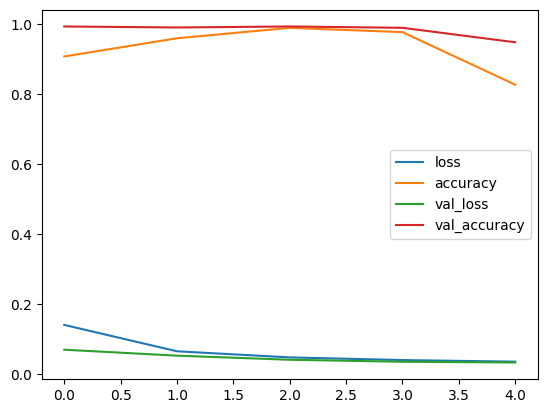

In [24]:
plt.figure(figsize = (5, 6))
pd.DataFrame(history.history).plot()
plt.show()

In [27]:
batch_X, batch_Y = test.as_numpy_iterator().next()

(model.predict(batch_X)>0.5).astype(int)

1/1 [==============================] - 0s 134ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0]])

In [28]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [29]:
pre = Precision()
rec = Recall()
cat = CategoricalAccuracy()

In [30]:
for batch in test.as_numpy_iterator():
    X_true, Y_true = batch
    y_hat = model.predict(X_true, verbose=0)

    Y_true = Y_true.flatten()
    y_hat = y_hat.flatten()

    pre.update_state(Y_true, y_hat)
    rec.update_state(Y_true, y_hat)
    cat.update_state(Y_true, y_hat)

print(f"Precision : {pre.result().numpy()},\n Recall : {rec.result().numpy()}, \n Categorical Accuracy :  {cat.result().numpy()}")

Precision : 0.9087837934494019,
 Recall : 0.7493036389350891, 
 Categorical Accuracy :  0.4693877696990967


In [31]:
model.save('model/toxic.h5')

/Users/mikosa/tensor/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [32]:
model_ = tf.keras.models.load_model('model/toxic.h5')

In [41]:
input_text = vectorizer('You are a ')
model.predict(np.expand_dims(input_text, 0))

1/1 [==============================] - 0s 136ms/step


array([[0.9986745 , 0.09083801, 0.9304521 , 0.02038666, 0.831484  ,
        0.09376907]], dtype=float32)

In [40]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [33]:
input_str = vectorizer('Hey I freaking hate you!!')

res = model_.predict(np.expand_dims(input_str, 0))
res>0.5

1/1 [==============================] - 1s 691ms/step


array([[ True, False, False, False, False, False]])